In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import math
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display
from util import fft_frequencies
import mappings
import pickle
import PIL

In [3]:
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)

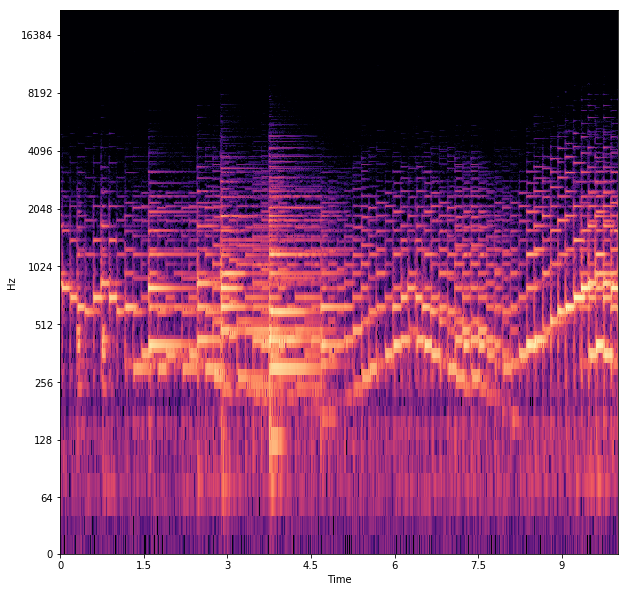

In [9]:
plt.figure(figsize=[10,10])
D = np.abs(librosa.stft(y, n_fft=2048))
ref = np.max(D)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=44100,  hop_length=512, y_axis='log', x_axis='time')

In [4]:
time_range = [1.2,3]
freq_range = [250, 300]

In [5]:
D_zoom, x_axis, y_axis = stft_zoom.stft_zoom(y, freq_range, time_range, sr)

ring mod + lpf


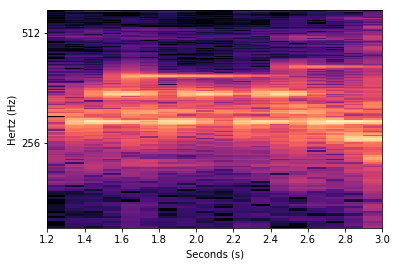

In [8]:
display.specshow(librosa.amplitude_to_db(D_zoom, ref=np.max), x_axis, y_axis, y_axis='log', x_axis='time')

In [3]:
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return (idx-1)
    else:
        return idx

In [4]:
class MultiResSpec(object):
    def __init__(self, data, sr, time_range):
        n_fft = 2 * (data.shape[0] - 1)
        self.y_axis = fft_frequencies(sr=sr, n_fft=n_fft) # freq centrais (Hz) dos bins
        self.x_axis = np.linspace(time_range[0], time_range[1], data.shape[1], endpoint=True) # tempo (s) dos frames
        self.data = data
        
    def insert_in_axis(old_axis, new_data):
        return np.sort(np.concatenate((old_axis, new_data)))
        
    def slice_data(data, y_axis_old, freq_range): # fatia o subespectro a ser inserido no intervalo freq_range
        n_fft = 2 * (data.shape[0] - 1)
#         fft_freqs = fft_frequencies(sr=sr, n_fft=n_fft) #freqs centrais dos bins a serem inseridos
#         fft_freqs = y_axis_old
        idx_start = find_nearest(y_axis_old, freq_range[0])
        if y_axis_old[idx_start] < freq_range[0]:
            idx_start += 1
        idx_stop = find_nearest(y_axis_old, freq_range[1])
        if y_axis_old[idx_stop] > freq_range[1]:
            idx_stop -= 1
        y_axis_new = y_axis_old[idx_start:idx_stop]
        return data[idx_start:idx_stop, :], y_axis_new
    
    def insert_subspec(self, new_data, y_axis, time_range, freq_range):
        x_axis_new = np.linspace(time_range[0], time_range[1], new_data.shape[1], endpoint=True)
        new_data_sliced, y_axis_new = MultiResSpec.slice_data(new_data, y_axis, freq_range)
        
        y_axis_complete = MultiResSpec.insert_in_axis(self.y_axis, y_axis_new)
        x_axis_complete = MultiResSpec.insert_in_axis(self.x_axis, x_axis_new)
        
        new_spec = np.zeros([len(y_axis_complete), len(x_axis_complete)])
        
        for i, freq in enumerate(y_axis_complete):
            for j, time_frame in enumerate(x_axis_complete):
                if time_frame >= time_range[0] and time_frame <= time_range[1] and freq >= freq_range[0] and freq <= freq_range[1]:
                    new_spec[i,j] = new_data_sliced[find_nearest(y_axis_new, freq), 
                                                   find_nearest(x_axis_new, time_frame)]
                else:
                    new_spec[i,j] = self.data[find_nearest(self.y_axis, freq), find_nearest(self.x_axis, time_frame)]
                    
        self.data = new_spec
        self.x_axis = x_axis_complete
        self.y_axis = y_axis_complete                

In [5]:
# Recebe um espectrograma, calcula um mapa de interesse musical e devolve uma lista ordenada de regiões
# mais interessantes
# A lista retornada são os índices flattened (retornar índices ou probs?) 
# ainda precisamos fazer o "unravel" e transformar em ranges

def detect_musical_regions(model, spectrogram, pct=3, kernel=[800, 800]):
    spec_amp = np.abs(spectrogram)
    spec_db = librosa.amplitude_to_db(spec_amp, ref=np.min)
    
    renyi = mappings.calc_map_aug2(spec_amp, kernel, type='renyi')
    shannon = mappings.calc_map_aug2(spec_db, kernel, type='shannon')
    
    X = np.array([shannon.flatten(), renyi.flatten()]).T
    predicted_probs = model.predict_proba(X)
    idx = int(len(renyi.flatten()) * (pct/100))
    return np.argsort(predicted_probs[:,1])[::-1][:idx], shannon.shape  # shape do mapa é usado depois em outras funções

In [6]:
# Devolve a lista de freqs que determinam os intervalos musicais em cents
# Ex: entre fft_freqs[idx_list[i]] e fft_freqs[idx_list[i+1]] há um intervalo de delta_f_c cents 
def find_freq_list(fft_freqs, delta_f_c):
    idx_list = [0]
    freq_step = fft_freqs[1]
    
    f1 = fft_freqs[1]
    f2 = f1 * 2 ** (delta_f_c/1200)
    idx_f1 = 0
    idx_f2 = int(np.ceil(f2/freq_step))
    
    while idx_f2 < len(fft_freqs):
        idx_list.append(idx_f2)
        idx_f1 = idx_f2
        f1 = fft_freqs[idx_f1]
        f2 = f1 * 2 ** (delta_f_c/1200)  
        idx_f2 = idx_f1 + int(np.ceil((f2 - f1)/freq_step))
        
    return idx_list

In [7]:
def kernel_to_ranges(x_span, x_size, kernel_size=[800,800], sr=44100, n_fft=2048, hop_size=512):
    freq_list = fft_frequencies(sr=sr, n_fft=n_fft)
    idx_list = find_freq_list(freq_list, kernel_size[1])
    freq_ranges = freq_list[idx_list]

    
    time_ranges = np.linspace(x_span[0], x_span[1], x_size+1)  # discussão: levar p/ reunião 
    return freq_ranges, time_ranges

def index_to_range(idx, freq_ranges, time_ranges):
    freq_range = [freq_ranges[idx[0]], freq_ranges[idx[0]+1]]
    time_range = [time_ranges[idx[1]], time_ranges[idx[1]+1]]
    return freq_range, time_range

In [8]:
# Recebe índices de regiões e devolve time_ranges e freq_ranges correspondentes
def musical_regions_to_ranges(indices, original_shape, freq_ranges, time_ranges):
    ranges = []
    for idx in indices:
        ranges.append(index_to_range(np.unravel_index(idx, original_shape), freq_ranges, time_ranges))
    return ranges

In [9]:
n_fft=2048
kernel=[800,800]
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)
spec = np.abs(librosa.stft(y, n_fft=n_fft))
time_span = [0,len(y)/sr]
MRSpec = MultiResSpec(spec, sr, time_span)
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))

indices, original_shape = detect_musical_regions(model, spec, pct=50)
x_size = original_shape[1]

freq_ranges, time_ranges = kernel_to_ranges(time_span, x_size)
to_be_refined = musical_regions_to_ranges(indices, original_shape, freq_ranges, time_ranges)

In [10]:
to_be_inserted = []

for subregion in to_be_refined[:]:

    freq_range = subregion[0]
    time_range = subregion[1]

    Y_zoom, x_axis, y_axis = stft_zoom.stft_zoom(y, freq_range, time_range, sr)
    to_be_inserted.append([Y_zoom, x_axis, y_axis, time_range, freq_range])

ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
ring mod + lpf
undersampl

In [12]:
for subregion in to_be_inserted:
    t_r = subregion[3]
    f_r = subregion[4]
    MRSpec.insert_subspec(subregion[0], subregion[2], t_r, f_r)

KeyboardInterrupt: 

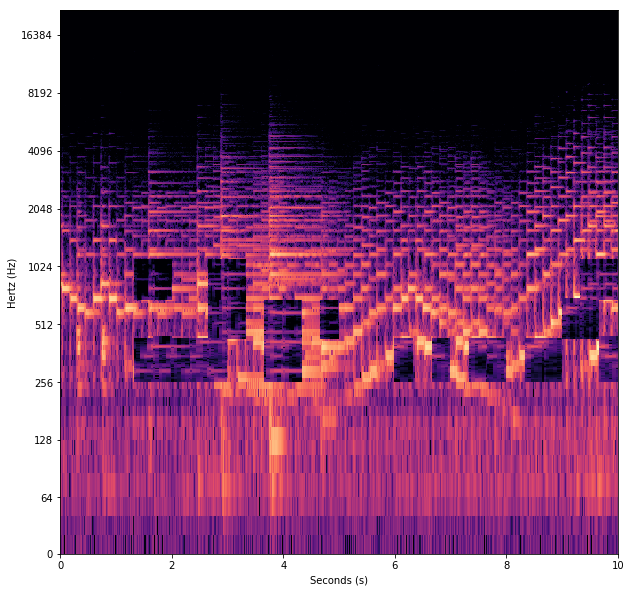

In [13]:
plt.figure(figsize=[10,10])
display.specshow(librosa.amplitude_to_db(MRSpec.data, ref=np.max), MRSpec.x_axis, MRSpec.y_axis, y_axis='log')

In [11]:
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return (idx-1)
    else:
        return idx

def insert_zoom(base_spec, zoom, time_range, freq_range, n_fft=2048, hop_size=512, sr=44100):
    y_axis = fft_frequencies(sr=sr, n_fft=n_fft)
    x_axis = librosa.core.frames_to_time(list(range(base_spec.shape[1])), sr=sr, hop_length=hop_size)
    
    x_start = find_nearest(x_axis, time_range[0])
    x_end =   find_nearest(x_axis, time_range[1])
    y_start = find_nearest(y_axis, freq_range[0])
    y_end =   find_nearest(y_axis, freq_range[1])
    
    zoom_img = PIL.Image.fromarray(zoom).resize((x_end - x_start,y_end - y_start))
    spec_img = PIL.Image.fromarray(base_spec)
    box = (x_start, y_start, x_end, y_end)
    spec_img.paste(zoom_img, box)
    
    return np.asarray(spec_img)

In [17]:
multires_spec = spec

for subregion in to_be_inserted[:50]:
    t_r = subregion[3]
    f_r = subregion[4]
    multires_spec = insert_zoom(multires_spec, subregion[0], t_r, f_r)

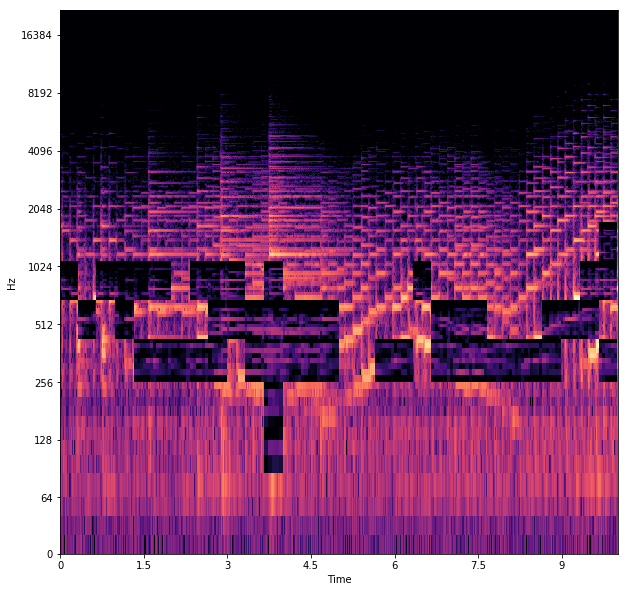

In [18]:
plt.figure(figsize=[10,10])
librosa.display.specshow(librosa.amplitude_to_db(multires_spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

In [18]:
y_test = y[:sr*5]

spec_1 = np.abs(librosa.stft(y_test, n_fft = 512))
spec_2 = np.abs(librosa.stft(y_test, n_fft = 10000))

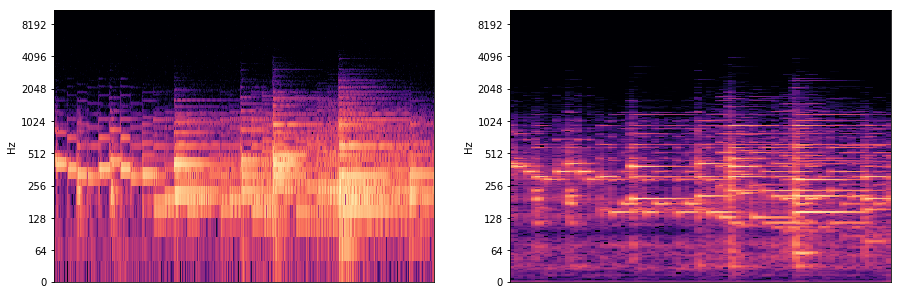

In [19]:
plt.figure(figsize=[15, 5])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec_1, ref=np.max), y_axis='log')

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(spec_2, ref=np.max), y_axis='log')